In [1]:
import random
from collections import deque
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from time import perf_counter

In [2]:
def brandes_single_source_dependencies_unweighted(G, s):
    S = []
    P = {v: [] for v in G}
    sigma = dict.fromkeys(G, 0.0)
    dist  = dict.fromkeys(G, -1)

    sigma[s] = 1.0
    dist[s] = 0

    from collections import deque
    Q = deque([s])

    while Q:
        v = Q.popleft()
        S.append(v)
        for w in G[v]:
            if dist[w] < 0:
                dist[w] = dist[v] + 1
                Q.append(w)
            if dist[w] == dist[v] + 1:
                sigma[w] += sigma[v]
                P[w].append(v)

    delta = dict.fromkeys(G, 0.0)
    while S:
        w = S.pop()
        for v in P[w]:
            if sigma[w] != 0:
                delta[v] += (sigma[v] / sigma[w]) * (1 + delta[w])

    return delta

In [3]:
def approx_bc_algorithm1_cutoff(G, cutoff_factor=20, seed=0):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    n = len(nodes)

    max_samples = max(1, n // cutoff_factor)
    print(f"[approx] using {max_samples} BFS samples (n/{cutoff_factor})")

    S = {v: 0.0 for v in nodes}
    k = {v: 0   for v in nodes}

    t0 = perf_counter()
    for i in range(max_samples):
        s = rng.choice(nodes)
        delta = brandes_single_source_dependencies_unweighted(G, s)
        for v in nodes:
            if v != s:
                S[v] += delta[v]
                k[v] += 1

    t1 = perf_counter()
    print(f"[approx] finished in {t1 - t0:.2f}s")

    bc_hat = {v: (n * S[v] / k[v]) if k[v] else 0 for v in nodes}
    return bc_hat

In [4]:
def smooth_series(y, window=51):
    w = max(3, int(window))
    if w % 2 == 0:
        w += 1
    if w > len(y):
        w = len(y) if len(y) % 2 == 1 else len(y) - 1
        if w < 3:
            return np.array(y, dtype=float)
    kernel = np.ones(w) / w
    ypad = np.pad(y, (w // 2, w // 2), mode='edge')
    return np.convolve(ypad, kernel, mode='valid')

Random Graph Experiment (Figure 1(a))

Random graph: 2000 7980
[approx] using 100 BFS samples (n/20)
[approx] finished in 0.35s


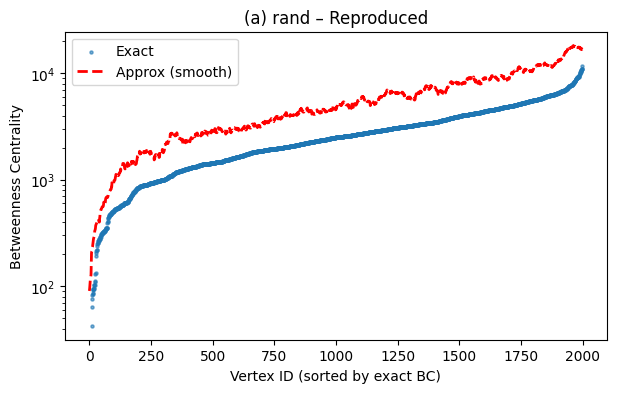

In [5]:
# ---- Generate random G(n,m) ----
G_rand = nx.gnm_random_graph(n=2000, m=7980, seed=42)

print("Random graph:", G_rand.number_of_nodes(), G_rand.number_of_edges())

# ---- Compute approximate ----
approx_rand = approx_bc_algorithm1_cutoff(G_rand, cutoff_factor=20)

# ---- Exact Brandes ----
exact_rand = nx.betweenness_centrality(G_rand, normalized=False)

# ---- Plot ----
nodes_sorted = sorted(exact_rand.keys(), key=lambda v: exact_rand[v])
x = np.arange(len(nodes_sorted))

y_exact = np.array([exact_rand[v] for v in nodes_sorted])
y_approx = np.array([approx_rand[v] for v in nodes_sorted])
y_smooth = smooth_series(y_approx)

plt.figure(figsize=(7,4))
plt.scatter(x, y_exact, s=5, alpha=0.6, label="Exact")
plt.plot(x, y_smooth, "r--", lw=2, label="Approx (smooth)")
plt.yscale("log")
plt.title("(a) rand – Reproduced")
plt.xlabel("Vertex ID (sorted by exact BC)")
plt.ylabel("Betweenness Centrality")
plt.legend()
plt.show()

Citation Network Experiment (Figure 1(e))

def load_cite(path="data"):
    G = nx.DiGraph()
    with open(path) as f:
        for line in f:
            parts = line.split()
            if len(parts) >= 2:
                u = int(parts[0])
                v = int(parts[1])
                G.add_edge(u, v)
    print("Cite graph:", G.number_of_nodes(), G.number_of_edges())
    return G

G_cite = load_cite()